# FINM 33150 Project Draft - Trading Volatility based on VIX Forecasts

Sean Lin (12375235) | Thomas McDonnell (12365628) | Ben Panovich (12365148) | Madison Rusch (12365298)

***

## 1 Introduction

In this notebook, we show the premise of what will become our quantitative trading strategy. As a quick summary, our trading strategy will involve capitalizing on volatility through the prediction of VIX. We will capitalize on this volatility by trading equity index options with a delta-hedged position in hopes to mitigate risk market directional risk. In addition, we will also trade other assets that move with volatility, notably futures, currencies, and bonds.

In [4]:
import os
import pandas as pd 
import numpy as np 
import functools 
import itertools
import quandl 
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import warnings
import matplotlib.pyplot as plt
import math
import datetime
import requests
import plotnine as p9
from plotnine import ggplot, aes, geom_histogram, labs, facet_wrap, theme, element_text, geom_line, geom_vline
import plotly.graph_objs as go
import plotly.offline as pyo

warnings.filterwarnings('ignore')

In [5]:
#KEY = os.getenv('QUANDL_KEY')
KEY = 'xpFGWP_Rsch8wawp_DLL'
quandl.ApiConfig.api_key = KEY # Insert your key here if you want to run the code yourself 


## 2 Data

For data, we'll be using a variety of data sources. More specifically, the majority of our price data will come from Quandl with historical options pricing data coming from Polygon. It's important to note that VIX price data isn't on Quandl and as a result, we obtained historical VIX data through CBOE's website. For prediction of VIX, we utilized the economic calendar, with data retrieved from [fxstreet.com](https://www.fxstreet.com/economic-calendar) and the Shanghai index, with data obtained from [investing.com](https://www.investing.com/indices/shanghai-composite). For some analysis, we also retrieved historical implied volatilities through the VOL Quandl database (though you may not have access if you haven't purchased the dataset). All the raw data is included with this notebook.

***

**2.1 Helper Functions**

We first define helper functions `fetch_quandl` and `fetch_quandl_table` to retrieve data from Quandl databases.

In [6]:
# TODO: Add documentation for function
@functools.lru_cache()
def fetch_quandl(asset, begin_date = None, end_date = None):
    '''
    Description

    Parameters:

    Returns:
    '''
    qdata = quandl.get(asset,
                      start_date = begin_date,
                      end_date = end_date,
                      paginate=True)
    return qdata

In [7]:
# TODO: Add documentation for function
@functools.lru_cache()
def fetch_quandl_table(table, ticker, begin_date = None, end_date = None):
    '''
    Description

    Parameters:

    Returns:
    '''
    qdata = quandl.get_table(table,
                      date = { 'gte': begin_date, 'lte': end_date },
                      qopts = {"columns":["date", "adj_close", "adj_volume"]},
                      ticker = ticker,
                      paginate=True)
    qdata = qdata.set_index('date').sort_index(ascending=True)
    return qdata

***

**2.1 Importing Model Data**

Here, we will import the data needed for our predictions and analysis for our time period. We will first collect the data needed for predicting VIX.

In [8]:
START_DATE = '2014-01-01'
END_DATE = '2022-12-23'

We will first collect VIX data. This was taken from CBOE's website. 

In [9]:
filename = './data/vix_data.csv'
vix_data = pd.read_csv(filename)
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])
vix_data = vix_data.set_index('DATE')[['CLOSE']]
vix_data = vix_data.loc[START_DATE:END_DATE]

We will now collect the economic calendar data. We obtain all the events considered *high importance* from FXStreet. In general, this consists of events like FOMC, CPI, Fed Chair Speeches, and Non-Farm Payroll.

In [10]:
filename = './data/economic_calendar.csv'
event_data = pd.read_csv(filename)
event_data['DATE'] = pd.to_datetime(event_data['Start']).dt.date
event_data = event_data.set_index('DATE')

# Obtain more economic calendar data 

When considering days until an event, we want to consider the weekends as options pricing uses a full calendar year, not trading years (i.e theta decay applies over weekends). Thus, we want to calculate the time until an event (including weekends).

In [11]:
idx = vix_data.index
all_dates = pd.date_range(START_DATE,END_DATE)

temp = vix_data.copy()
temp.columns = ['VIX']
temp = temp.reindex(idx, fill_value=None)
temp['Event'] = np.where(temp.index.isin(event_data.index.values), True, False)
temp['Days until Event'] = np.where(temp['Event'] == True, 0, vix_data.groupby((temp['Event'] == True).cumsum()).cumcount(ascending=False)+1)
temp = temp.dropna(subset=['VIX'])
temp = temp[['VIX', 'Days until Event']]

We will now obtain SPY data. We only want to consider US trading days. In other words, we only want to look at dates where SPY has a close (even if it's an early close).

In [12]:
spy_data = fetch_quandl_table('QUOTEMEDIA/PRICES','SPY',begin_date=START_DATE,end_date=END_DATE)
spy_data.columns = ['SPY', 'SPY Volume']
trading_days = spy_data.index 
temp = temp.loc[temp.index.isin(trading_days)]

We will now import the Shanghai index data. This is used as the Shanghai Stock Exchange closes before the US Stock Exchange opens. This could potentially give us valuable information on the behavior of VIX during the next day as the global markets usually have some type of correlation.

In [13]:
filename = './data/ssec_data.csv'
ssec_data = pd.read_csv(filename)
ssec_data['Date'] = pd.to_datetime(ssec_data['Date'])
ssec_data = ssec_data.set_index('Date')
ssec_data = ssec_data.loc[ssec_data.index.isin(trading_days)].sort_index(ascending=True)
ssec_data = ssec_data[['Price']].rename(columns={'Price':'SSEC'})
ssec_data = ssec_data['SSEC'].str.replace(',','').astype(float).to_frame()

We'll now import Crude Oil futures data (CL). Since futures have quarterly expires, we will roll these over. 

In [14]:
securities = ['OWF/NYM_CL_CL']
dates = ['H2014', 'M2014', 'U2014', 'Z2014',
         'H2015', 'M2015', 'U2015', 'Z2015',
         'H2016', 'M2016', 'U2016', 'Z2016',
         'H2017', 'M2017', 'U2017', 'Z2017',
         'H2018', 'M2018', 'U2018', 'Z2018',
         'H2019', 'M2019', 'U2019', 'Z2019',
         'H2020', 'M2020', 'U2020', 'Z2020',
         'H2021', 'M2021', 'U2021', 'Z2021', 
         'H2022', 'M2022', 'U2022', 'Z2022',
         'H2023']

# Fetch NYM_RB_RB Data
finalized_data = pd.DataFrame()
security = securities[0]
trim_start = START_DATE
trim_end = END_DATE
for month in tqdm(dates):
  data = fetch_quandl(f'{security}_{month}_IVM', begin_date=trim_start, end_date=trim_end)
  if finalized_data.empty:
    finalized_data = data
  else:
    finalized_data = pd.concat([finalized_data, data])
  trim_start = finalized_data.index[-1] + pd.DateOffset(1)

cl_data = finalized_data.copy()[['Future']].rename(columns={'Future':'CL'})

100%|██████████| 37/37 [00:09<00:00,  4.07it/s]


In [15]:
all_data = pd.concat([temp, spy_data, ssec_data, cl_data], axis=1)

all_data['VIX Returns'] = all_data['VIX'].pct_change()
all_data['SPY Returns'] = all_data['SPY'].pct_change()
all_data['SSEC Returns'] = all_data['SSEC'].pct_change()
all_data['CL Returns'] = all_data['CL'].pct_change()

predictors = all_data[['Days until Event','SPY Volume','VIX Returns','SPY Returns','SSEC Returns','CL Returns']].dropna()

In [16]:
predictors['VIX Returns (y)'] = predictors['VIX Returns'].shift(-1)
predictors['SSEC Returns'] = predictors['SSEC Returns'].shift(-1)
predictors = predictors.drop(columns=['VIX Returns'])

predictors = predictors.dropna()

Now that we have all predictor data, let's analyze the returns data on VIX, SPY, SSEC, and Crude Oil.

In [17]:
return_data = all_data[['VIX Returns', 'SPY Returns', 'SSEC Returns', 'CL Returns']]
return_data = return_data.dropna()
all_data.describe()

,VIX,Days until Event,SPY,SPY Volume,SSEC,CL,VIX Returns,SPY Returns,SSEC Returns,CL Returns
count,2262.000000,2262.000000,2262.000000,2.262000e+03,2117.000000,2331.000000,2330.000000,2330.000000,2330.000000,2330.000000
mean,18.257657,1.662688,267.562872,9.378756e+07,3107.531370,62.212214,0.003514,0.000451,0.000243,0.000381
std,7.633197,1.980849,90.114860,4.796567e+07,475.071469,19.947395,0.085996,0.011138,0.013019,0.029793
min,9.140000,0.000000,147.460782,2.027001e+07,1993.480000,11.570000,-0.259057,-0.109424,-0.084907,-0.433676
25%,13.020000,0.000000,183.667287,6.204491e+07,2898.580000,48.400000,-0.043798,-0.003518,-0.004626,-0.011768
50%,16.045000,1.000000,250.552287,8.112095e+07,3136.640000,57.350000,-0.005686,0.000441,0.000000,0.000526
75%,21.647500,3.000000,327.134030,1.107027e+08,3373.280000,71.865000,0.035993,0.005394,0.005608,0.012453
max,82.690000,12.000000,470.063508,5.072443e+08,5166.350000,117.150000,1.155979,0.090603,0.078403,0.250996


Let's further analyze the data by creating some histograms.

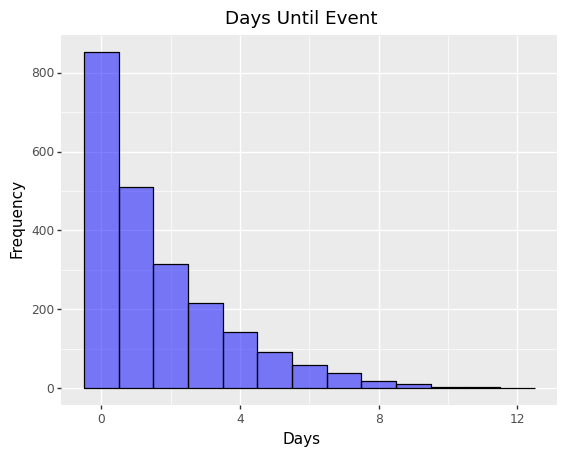

<ggplot: (8774687681274)>

In [18]:
(ggplot() 
 + aes(x=all_data[['Days until Event']])
 + geom_histogram(binwidth=1, color='black', fill='blue', alpha=0.5) 
 + labs(x='Days', y='Frequency', title='Days Until Event')
)

This graph makes apparent that there are high impact events on the US Dollar most days of our dataset, with the majority of the 'Days until Event' data clustered around zero days until event. At the edges of the data, we have at most 12 days until an event.

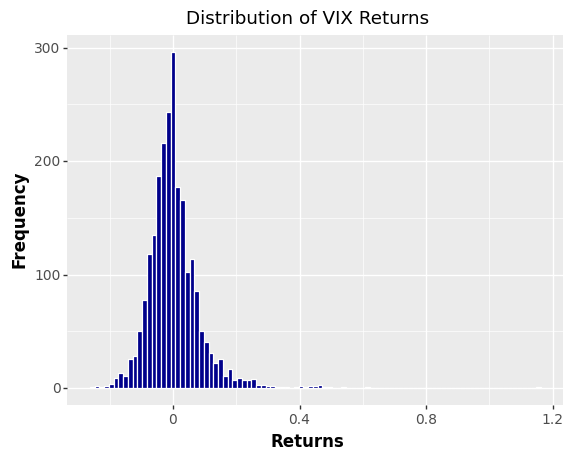

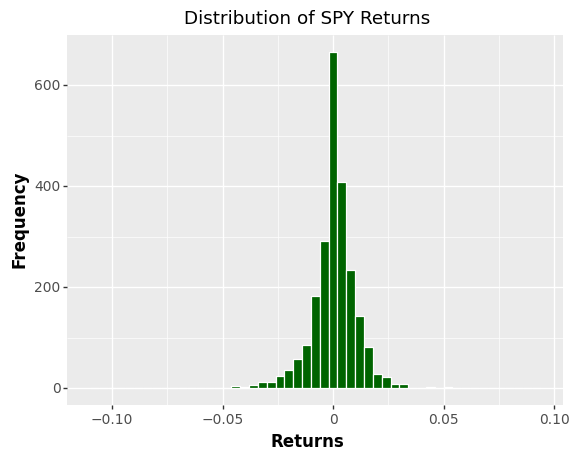

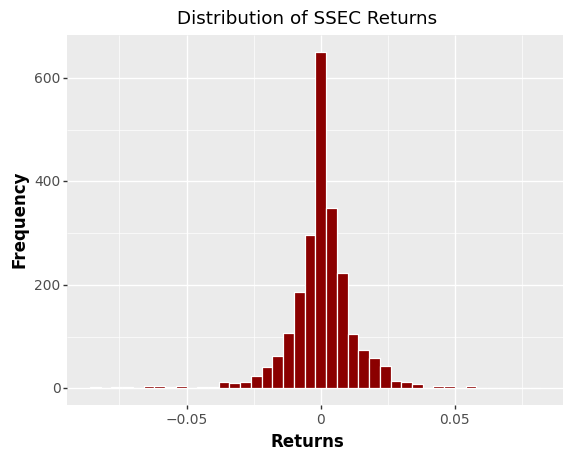

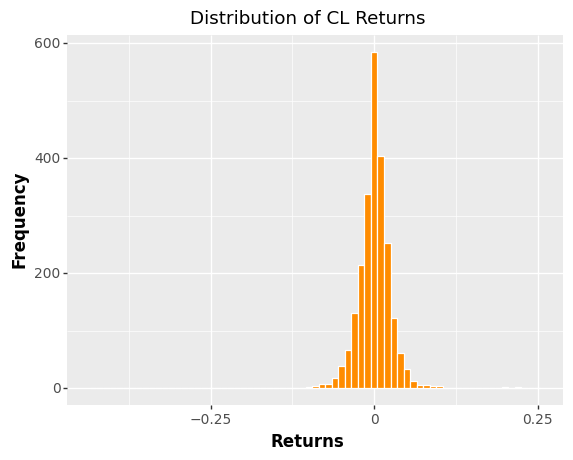

(<ggplot: (8774672320250)>,
 <ggplot: (8774672334333)>,
 <ggplot: (8774672340989)>,
 <ggplot: (8774672338746)>)

In [19]:
hist1 = (ggplot(all_data, aes(x='VIX Returns'))
         + geom_histogram(binwidth=.015, color='white', fill='darkblue')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of VIX Returns')
        )
hist2 = (ggplot(all_data, aes(x='SPY Returns'))
         + geom_histogram(binwidth=.004, color='white', fill='darkgreen')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of SPY Returns')
        )
hist3 = (ggplot(all_data, aes(x='SSEC Returns'))
         + geom_histogram(binwidth=.004, color='white', fill='darkred')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of SSEC Returns')
        )
hist4 = (ggplot(all_data, aes(x='CL Returns'))
                + geom_histogram(binwidth=.01, color='white', fill='darkorange')
                + theme(axis_text=element_text(size=10),
                        axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of CL Returns')
        )
hist1,hist2,hist3,hist4

The histograms above on VIX, SPY, SSEC, and CL show that the returns on this data are approximately normally distributed, as is to be expected when analyzing returns over a window this large.

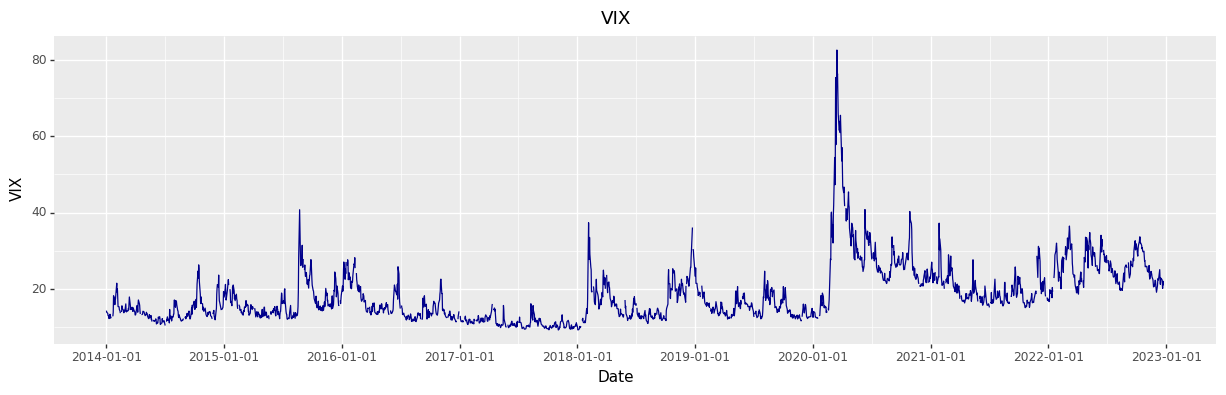

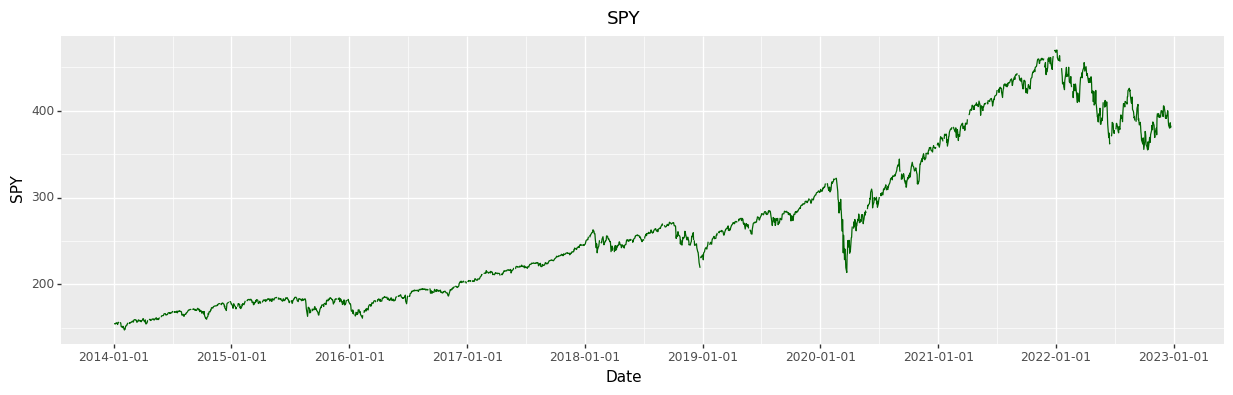

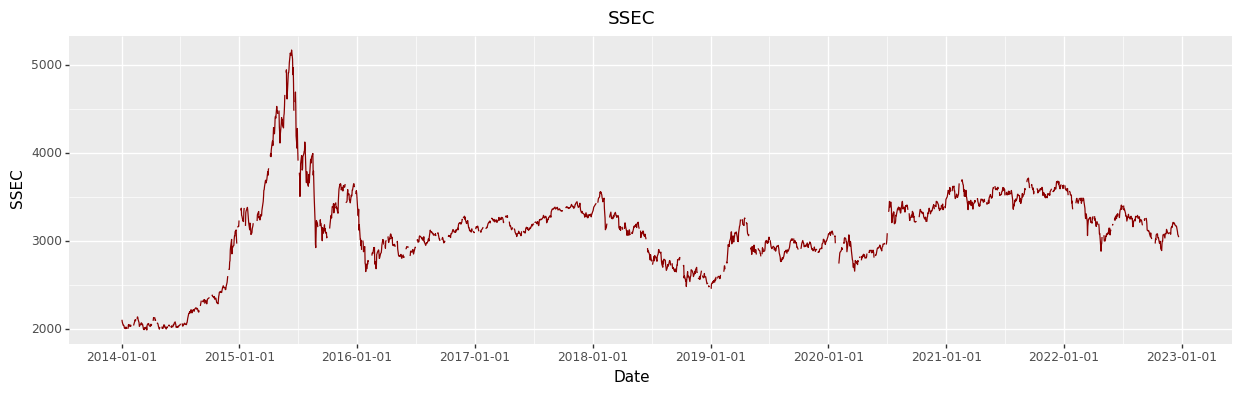

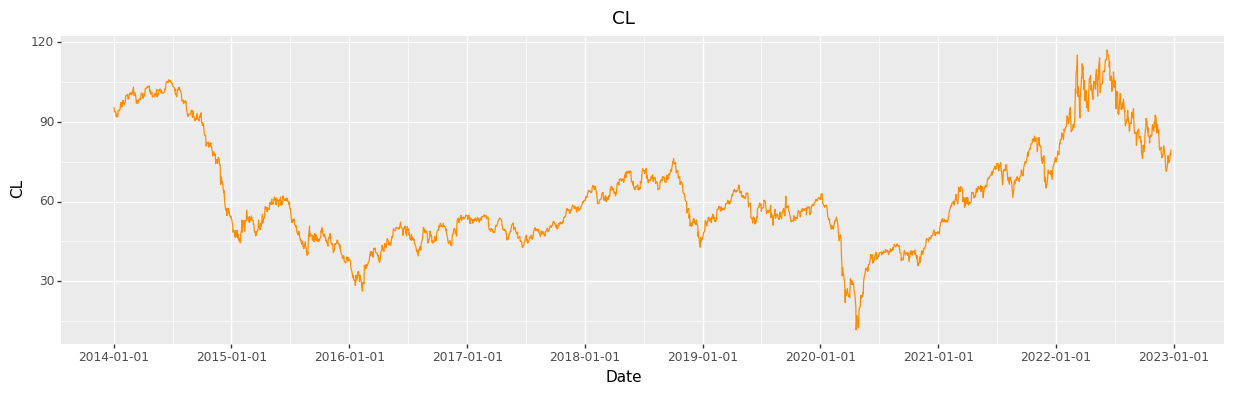

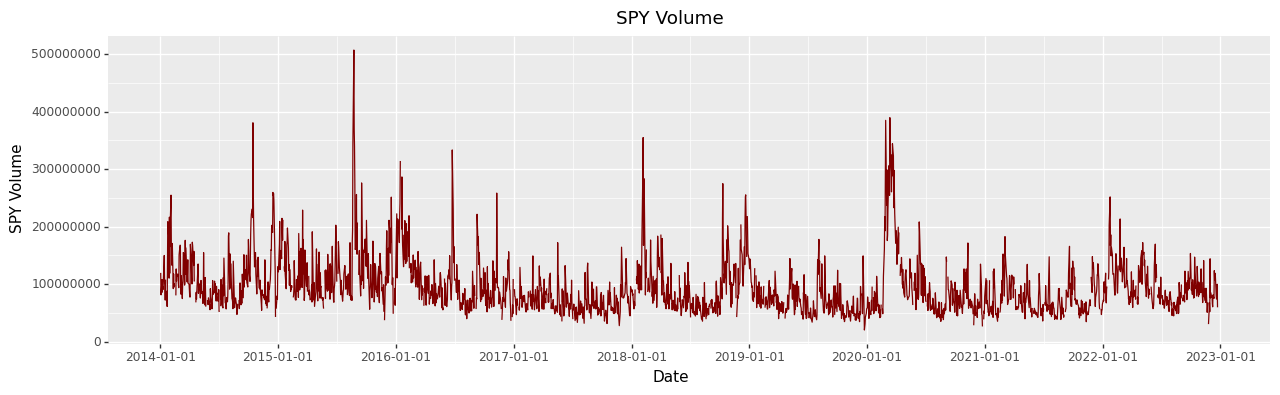

(<ggplot: (8774652375664)>,
 <ggplot: (8774672235493)>,
 <ggplot: (8774672314757)>,
 <ggplot: (8774687839678)>,
 <ggplot: (8774687865947)>)

In [20]:
vix = (ggplot(all_data[['VIX']], aes(x=all_data.index, y='VIX'))
        + geom_line(color='darkblue')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='VIX', title='VIX')
       )
spy = (ggplot(all_data[['SPY']], aes(x=all_data.index, y='SPY'))
        + geom_line(color='darkgreen')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='SPY', title='SPY')
        )
ssec = (ggplot(all_data[['SSEC']], aes(x=all_data.index, y='SSEC'))
        + geom_line(color='darkred')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='SSEC', title='SSEC')
        )
cl = (ggplot(all_data[['CL']], aes(x=all_data.index, y='CL'))
        + geom_line(color='darkorange')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='CL', title='CL')
        )
spy_volume = (ggplot(all_data[['SPY Volume']], aes(x=all_data.index, y='SPY Volume'))
        + geom_line(color='maroon')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='SPY Volume', title='SPY Volume')
        )
vix,spy,ssec,cl,spy_volume

Now that we have explored the data for potential VIX predictors, we believe we can use them to form an accurate forecast of 1 day future VIX, which will eventually act as a signal for our trading strategy.

***

# 3 Predicting VIX

To predict VIX, we will select a training set of days from 2014 to 2020 and use an ARIMA model to then get values for 2021 through 2022.

In [21]:
START_TRAIN = '2014-01-03'
END_TRAIN = '2014-06-03'

START_TEST = END_TRAIN 
END_TEST = '2020-12-31'

START_VAL = END_TEST 
END_VAL = '2022-12-22'

ROLLING = True

arima_data = predictors.loc[START_TRAIN:END_TEST]

last_train = arima_data.loc[:END_TRAIN].index[-1]
end_train_loc = arima_data.index.get_loc(last_train)

In [22]:
def test_model(p,d,q,thresh_up,thresh_down):
    metrics = pd.DataFrame(index=[str((p,d,q))],columns=['MSE','DA','Up Acc','Down Acc','Tot Significant'])
    predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_TEST].index,columns=['predictions'])
    start, end = 0, end_train_loc 
    for i in range(len(arima_data.loc[START_TEST:END_TEST])):
        model = ARIMA(arima_data.iloc[start:end]['VIX Returns (y)'], order=(p,d,q), exog=arima_data.iloc[start:end,:5]).fit()
        forecast = model.forecast(1, exog=arima_data.iloc[end,:5])

        if ROLLING == True:
            start = start + 1 
        end = end + 1 

        predicted_results.iloc[i] = forecast

    predicted_results = predicted_results.dropna()
    predicted_results['actual'] = arima_data.loc[START_TEST:END_TEST,'VIX Returns (y)']

    mse = np.mean((predicted_results['actual'] - predicted_results['predictions']) ** 2)
    da = (np.sign(predicted_results['predictions']) == np.sign(predicted_results['actual'])).sum() / len(predicted_results)

    significant_up = predicted_results[predicted_results['predictions'] > thresh_up]
    acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
    significant_down = predicted_results[predicted_results['predictions'] < thresh_down]
    acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
    total_sig = len(significant_up) + len(significant_down)

    metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
    return metrics, predicted_results

In [23]:
param_grid = {
    'p': range(0,5),
    'd': range(0,3),
    'q': range(0,5)
}

param_combinations = list(itertools.product(*(param_grid[param] for param in param_grid)))

def optimize(params):
    p, d, q = params
    metric = test_model(p,d,q,0.07,-0.07)
    return metric 

To optimize our ARIMA parameters, we will use an initial training period of 6m (2014-01 - 2014-06). We will use a rolling window to forecast predictions until the end of 2020. We will then determine our best model based on this period. After selecting the best model, we will use this to test out-of-sample on our validation period.

In [24]:
RUN_OPTIMIZATION = False 

if RUN_OPTIMIZATION:
    optimization_res = pd.DataFrame(columns=['MSE','DA','Up Acc','Down Acc','Tot Significant'])
    for combo in tqdm(param_combinations):
        p, d, q = combo 
        metric = test_model(p,d,q,0.07,-0.07)
        optimization_res.loc[str((p,d,q))] = metric.values[0]
else:
    optimization_res = pd.read_csv('./data/optimization_stats.csv',index_col=0)

In [25]:
optimization_res.sort_values(by='DA',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 0, 1)",0.009271,0.514768,0.500000,0.821429,70
"(4, 1, 4)",0.014459,0.512960,0.448276,0.544118,310
"(3, 2, 4)",0.027534,0.512357,0.448622,0.557841,788
"(0, 1, 0)",0.014551,0.510549,0.448889,0.534483,399
"(1, 0, 0)",0.009306,0.510549,0.512195,0.785714,69


In [26]:
optimization_res.sort_values(by='Up Acc',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(4, 0, 3)",0.010521,0.490054,0.535714,0.625000,112
"(1, 0, 0)",0.009306,0.510549,0.512195,0.785714,69
"(1, 0, 1)",0.009675,0.510549,0.510204,0.766667,79
"(2, 0, 2)",0.010837,0.506329,0.507463,0.693878,116
"(4, 0, 4)",0.011393,0.486438,0.506024,0.688525,144


In [27]:
optimization_res.sort_values(by='Down Acc',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 0, 1)",0.009271,0.514768,0.500000,0.821429,70
"(0, 0, 0)",0.009181,0.504521,0.461538,0.814815,66
"(1, 0, 0)",0.009306,0.510549,0.512195,0.785714,69
"(2, 0, 0)",0.009378,0.499096,0.431818,0.777778,80
"(1, 0, 1)",0.009675,0.510549,0.510204,0.766667,79


Best ones:
- (0,0,1) looks to be most robust one (highest directional accuracy for a simple TS model)
- (4,1,4) and (3,2,4) also have high directional accuracy, so we should consider them as well

**Testing out of sample**

Now that we've optimized, let's forecast the values on our out of sample timeframe, 2021-2022, using the three ARIMA models listed above with the highest directional accuracy.

In [28]:
validation_data = predictors.loc[START_TRAIN:END_VAL]
p, d, q = 0, 0, 1

last_test= validation_data.loc[:END_TRAIN].index[-1]
end_test_loc = validation_data.index.get_loc(last_test)

metrics = pd.DataFrame(columns=['MSE','DA','Up Acc','Down Acc','Tot Significant'])
predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_VAL].index,columns=['predictions'])
start, end = 0, end_test_loc 
for i in tqdm(range(len(validation_data.loc[START_TEST:END_VAL]))):
    model = ARIMA(validation_data.iloc[start:end]['VIX Returns (y)'], order=(p,d,q), exog=validation_data.iloc[start:end,:5]).fit()
    forecast = model.forecast(1, exog=validation_data.iloc[end,:5])

    if ROLLING == True:
        start = start + 1 
    end = end + 1 

    predicted_results.iloc[i] = forecast

predicted_results = predicted_results.dropna()
predicted_results['actual'] = validation_data.loc[START_TEST:END_VAL,'VIX Returns (y)']
predicted_results_val = predicted_results.loc[START_VAL:END_VAL]

100%|██████████| 2157/2157 [01:56<00:00, 18.58it/s]


In [29]:
trace1 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['actual'], mode='lines', name='actual')
trace2 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['predictions'], mode='lines', name='predicted')
data = [trace1, trace2]
layout = go.Layout(title='Actual vs Predicted', xaxis=dict(title='Date'), yaxis=dict(title='VIX Returns'), legend=dict(x=0, y=1.0, orientation='h'))
fig = go.Figure(data=data, layout=layout)
fig

In [30]:
pos_thres = 0.07
neg_thres = -0.07

mse = np.mean((predicted_results_val['actual'] - predicted_results_val['predictions']) ** 2)
da = (np.sign(predicted_results_val['predictions']) == np.sign(predicted_results_val['actual'])).sum() / len(predicted_results_val)

significant_up = predicted_results_val[predicted_results_val['predictions'] > pos_thres]
acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
significant_down = predicted_results_val[predicted_results_val['predictions'] < neg_thres]
acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
total_sig = len(significant_up) + len(significant_down)

metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
display(metrics)

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 0, 1)",0.007488,0.466934,NaN,0.5,6.0


In [31]:
validation_data = predictors.loc[START_TRAIN:END_VAL]
p, d, q = 4, 1, 4

last_test= validation_data.loc[:END_TRAIN].index[-1]
end_test_loc = validation_data.index.get_loc(last_test)

predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_VAL].index,columns=['predictions'])
start, end = 0, end_test_loc 
for i in tqdm(range(len(validation_data.loc[START_TEST:END_VAL]))):
    model = ARIMA(validation_data.iloc[start:end]['VIX Returns (y)'], order=(p,d,q), exog=validation_data.iloc[start:end,:5]).fit()
    forecast = model.forecast(1, exog=validation_data.iloc[end,:5])

    if ROLLING == True:
        start = start + 1 
    end = end + 1 

    predicted_results.iloc[i] = forecast

predicted_results = predicted_results.dropna()
predicted_results['actual'] = validation_data.loc[START_TEST:END_VAL,'VIX Returns (y)']
predicted_results_val = predicted_results.loc[START_VAL:END_VAL]

100%|██████████| 2157/2157 [04:10<00:00,  8.60it/s]


In [32]:
pos_thres = 0.07
neg_thres = -0.07

mse = np.mean((predicted_results_val['actual'] - predicted_results_val['predictions']) ** 2)
da = (np.sign(predicted_results_val['predictions']) == np.sign(predicted_results_val['actual'])).sum() / len(predicted_results_val)

significant_up = predicted_results_val[predicted_results_val['predictions'] > pos_thres]
acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
significant_down = predicted_results_val[predicted_results_val['predictions'] < neg_thres]
acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
total_sig = len(significant_up) + len(significant_down)

metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
display(metrics)

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 0, 1)",0.007488,0.466934,NaN,0.500000,6.0
"(4, 1, 4)",0.011710,0.464930,0.347826,0.551724,75.0


In [33]:
trace1 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['actual'], mode='lines', name='actual')
trace2 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['predictions'], mode='lines', name='predicted')
data = [trace1, trace2]
layout = go.Layout(title='Actual vs Predicted', xaxis=dict(title='Date'), yaxis=dict(title='VIX Returns'), legend=dict(x=0, y=1.0, orientation='h'))
fig = go.Figure(data=data, layout=layout)
fig

In [35]:
trace1 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['actual'], mode='lines', name='actual')
trace2 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['predictions'], mode='lines', name='predicted')
data = [trace1, trace2]
layout = go.Layout(title='Actual vs Predicted', xaxis=dict(title='Date'), yaxis=dict(title='VIX Returns'), legend=dict(x=0, y=1.0, orientation='h'))
fig = go.Figure(data=data, layout=layout)
fig

In [36]:
pos_thres = 0.07
neg_thres = -0.07

mse = np.mean((predicted_results_val['actual'] - predicted_results_val['predictions']) ** 2)
da = (np.sign(predicted_results_val['predictions']) == np.sign(predicted_results_val['actual'])).sum() / len(predicted_results_val)

significant_up = predicted_results_val[predicted_results_val['predictions'] > pos_thres]
acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
significant_down = predicted_results_val[predicted_results_val['predictions'] < neg_thres]
acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
total_sig = len(significant_up) + len(significant_down)

metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
display(metrics)

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 0, 1)",0.007488,0.466934,NaN,0.500000,6.0
"(4, 1, 4)",0.011710,0.464930,0.347826,0.551724,75.0
"(3, 2, 4)",0.023647,0.476954,0.358333,0.533898,238.0


In the table above, we can see that our predictive model accurately predicts daily VIX returns of over positive 7%, 42% of the time. It also accurately

The graphs above show that while our predictive model is not a perfect estimation, it does get large swings in the VIX generally correct, which we will take as a good sign for using it as a signal in our trading strategy.

***

# 4 Tradeable Assets

Now that we believe we have a relatively accurate prediction of VIX returns, we will think about the trading strategies that we can execute using this information. To do this, we will attept to find tradeable assets whose returns are strongly positively or negatively correlated to VIX returns. We will assume that we are going to trade SPY ETF options and SPY ETF in order to delta hedge. We also want to trade Commodity Futures, Currencies, and Bonds, and will analyze several different assets to find the highest magnitude correlations.

### SPY Options

Below is an example contract of SPY which shows how we can get the price data of SPY Options. For our initial attempts at the trading strategy, we will plan on buying at the money call options when VIX returns reach some positive threshold, and holding them for two days. This will be optimized when we actually start to analyze the trades.

In [37]:
@functools.lru_cache()
def fetch_options_price(option,date):
    data_url = f'https://api.polygon.io/v1/open-close/{option}/{date}?adjusted=true&apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    response = requests.get(data_url)
    if response.status_code == 200:
        return response.json()
    else:
        return response.status_code

In [38]:
def retrieve_options(date):
    dates = spy_data.loc[date:].index[:20]
    atm_put_strike = math.ceil(spy_data.loc[dates[0],'SPY'])
    atm_call_strike = math.floor(spy_data.loc[dates[0],'SPY'])
    
    i = -10 
    call = 404 
    while call == 404:
        last_date = dates[i].strftime('%y%m%d')
        call_code = 'O:SPY' + last_date + 'C' + '00' + str(atm_call_strike) + '000'
        put_code = 'O:SPY' + last_date + 'P' + '00' + str(atm_put_strike) + '000'
        call = fetch_options_price(call_code, date)
        i = i + 1 

    last_date = datetime.datetime.strptime(last_date,'%y%m%d')
    last_date = last_date.strftime('%Y-%m-%d')
    valid_dates = spy_data.loc[dates[0]:last_date].index

    option_prices = pd.DataFrame(index=valid_dates,columns=[call_code,put_code,'SPY'])
    for day in option_prices.index:
        call_res = fetch_options_price(call_code, day.strftime('%Y-%m-%d'))
        put_res = fetch_options_price(put_code, day.strftime('%Y-%m-%d'))

        if not isinstance(call_res, int):
            option_prices.loc[day,call_code] = call_res['close']

        if not isinstance(put_res, int):
            option_prices.loc[day,put_code] = put_res['close']

    option_prices['SPY'] = spy_data.loc[dates[0]:last_date,'SPY']

    return option_prices 

In [39]:
retrieve_options('2022-02-23') # russian invasion 

,O:SPY220309C00415000,O:SPY220309P00416000,SPY
date,,,
2022-02-23,14.88,6.89,415.196034
2022-02-24,16.69,4.32,421.444392
2022-02-25,24.46,2.16,430.743130
2022-02-28,23.81,3.2,429.641057
2022-03-01,18.49,3.71,423.097501
2022-03-02,21.12,1.49,430.880889
2022-03-03,24.41,1.45,428.735783
2022-03-04,17.5,1.37,425.252447
2022-03-07,7.04,3.67,412.716370


### SPY ETF

In [40]:
display(all_data[['SPY','SPY Returns']])

,SPY,SPY Returns
2014-01-02,154.868957,NaN
2014-01-03,154.843559,-0.000164
2014-01-06,154.394837,-0.002898
2014-01-07,155.343079,0.006142
2014-01-08,155.376951,0.000218
...,...,...
2022-12-19,380.020000,-0.008480
2022-12-20,380.540000,0.001368
2022-12-21,386.230000,0.014952
2022-12-22,380.720000,-0.014266


### Commodity Futures

We selected the following eight commodity futures returns, rolled over quarterly, to determine which will have the best returns correlated to VIX returns.
- Gold
- Silver
- Natural Gas
- Gasoline
- Live Cattle
- Wheat 
- Crude Oil
- Corn

In [41]:
securities = [
              'OWF/CMX_GC_GC', # Gold
              'OWF/CMX_SI_SI', # Silver
              'OWF/NYM_NG_NG', # Natural Gas
              'OWF/NYM_RB_RB', # Gasoline
              'OWF/CME_LC_LC', # Live Cattle
              'OWF/CBT_W_W',   # Wheat
              'OWF/NYM_CL_CL', # Crude Oil
              'OWF/CBT_C_C',   # Corn
              ]
dates = [
         'H2014', 'M2014', 'U2014', 'Z2014',
         'H2015', 'M2015', 'U2015', 'Z2015',
         'H2016', 'M2016', 'U2016', 'Z2016',
         'H2017', 'M2017', 'U2017', 'Z2017',
         'H2018', 'M2018', 'U2018', 'Z2018',
         'H2019', 'M2019', 'U2019', 'Z2019',
         'H2020']

prices = pd.DataFrame(index = pd.date_range('2014-01-01', '2019-12-31'))
for security in securities[0:]:
  finalized_data = pd.DataFrame()
  trim_start = "2014-01-01"
  trim_end = "2019-12-31"
  for month in dates:
    data = fetch_quandl(f'{security}_{month}_IVM', begin_date=trim_start, end_date=trim_end)
    if finalized_data.empty:
      finalized_data = data
    else:
      finalized_data = finalized_data.append(data)
    trim_start = finalized_data.index[-1] + pd.DateOffset(1)
  prices[security] = finalized_data['Future']

prices=prices.dropna()
commodities_price_returns = prices.pct_change()

In [42]:
correlations_to_vix = pd.DataFrame(columns=['Correlations to VIX'])
for column in commodities_price_returns.columns.values:
    vix_returns = all_data['VIX Returns']
    correlations_to_vix.loc[column[4:]] = (commodities_price_returns[column]).corr(vix_returns[abs(vix_returns) > 0.07])
display(correlations_to_vix)

,Correlations to VIX
CMX_GC_GC,0.193216
CMX_SI_SI,-0.034657
NYM_NG_NG,-0.055462
NYM_RB_RB,-0.244518
CME_LC_LC,-0.054187
CBT_W_W,-0.100768
NYM_CL_CL,-0.286999
CBT_C_C,-0.122335


We can see in the above table that Gold is positively correlated to VIX Returns of above 7% in our training period of 2014-2019. This would imply we should trade Gold futures during our trading strategy when we predict VIX Returns above 0.07. We decided to not trade Crude Oil because it ended up being a significant factor in our predictive model, and we decided not to trade Gasoline because of its high correlation to Crude Oil. We addiionally decided not to trade other commodity futures due to the additional market frictions of shorting.

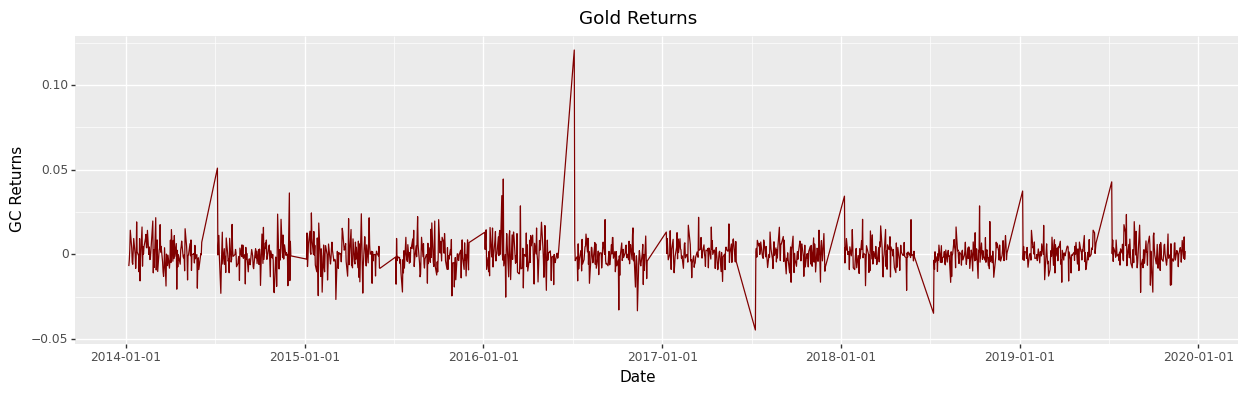

<ggplot: (8774672620797)>

In [43]:
gold_returns = (ggplot(commodities_price_returns[['OWF/CMX_GC_GC']], aes(x=commodities_price_returns.index, y='OWF/CMX_GC_GC'))
        + geom_line(color='maroon')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='GC Returns', title='Gold Returns')
        )
gold_returns

### Currencies

Next we will analyze currencies, to see if there are any trends between Currency spot rates and VIX Returns.

In [44]:
currencies = ['CUR/GBP', 'CUR/AUD', 'CUR/CAD', 'CUR/CHF', 'CUR/CNY', 'CUR/EUR', 'CUR/HKD', 'CUR/INR', 'CUR/JPY', 'CUR/MXN']
currency_correlations = pd.DataFrame(columns=['Correlations to VIX'])
for currency in currencies:
    returns = fetch_quandl(currency, begin_date='2014-01-01', end_date='2019-12-31')['RATE'].pct_change()
    vix_returns = all_data['VIX Returns']
    currency_correlations.loc[currency] = (returns).corr(vix_returns[abs(vix_returns) > 0.07])
display(currency_correlations)

,Correlations to VIX
CUR/GBP,0.136081
CUR/AUD,0.177399
CUR/CAD,0.119995
CUR/CHF,-0.103724
CUR/CNY,0.044952
CUR/EUR,0.017284
CUR/HKD,0.096604
CUR/INR,0.272125
CUR/JPY,-0.261816
CUR/MXN,0.280777


Based on the spot rate correlation above, we see that the Japanese Yen increases in value when VIX goes up. As a result, we will short USDJPY to profit on the strengthening Yen.

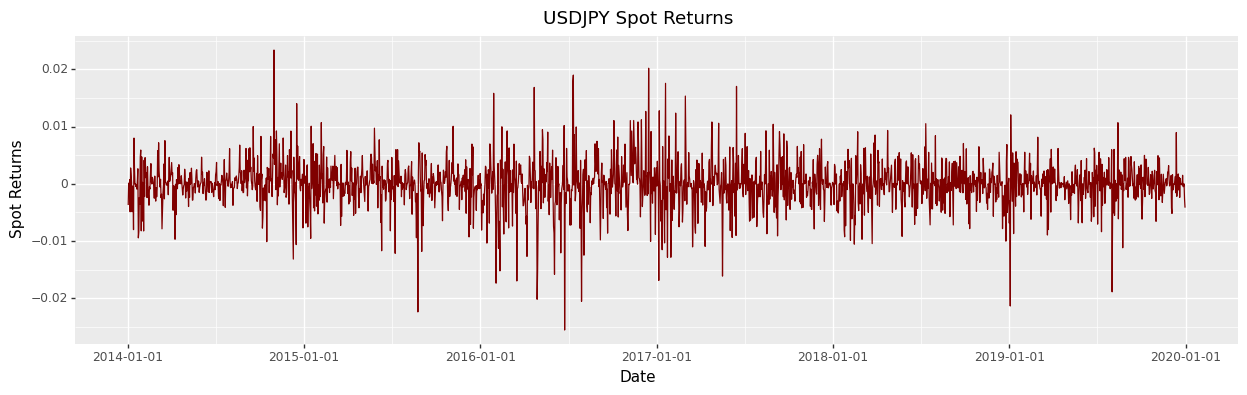

<ggplot: (8774672180652)>

In [45]:
usdjpy_returns = pd.DataFrame(data=fetch_quandl('CUR/JPY', begin_date='2014-01-01', end_date='2019-12-31')['RATE'].pct_change())
usdjpy_returns = usdjpy_returns.dropna()
jpy_returns = (ggplot(usdjpy_returns[['RATE']], aes(x=usdjpy_returns.index, y='RATE'))
        + geom_line(color='maroon')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='Spot Returns', title='USDJPY Spot Returns')
        )
jpy_returns

### Bonds

Lastly, we will see if there are any correlations between US Treasury yields and the VIX.

In [46]:
bond_data = fetch_quandl('YC/USA10Y', begin_date='2014-01-02', end_date='2019-12-31')
bond_data['Returns'] = bond_data['Rate'].pct_change()
corr = bond_data['Returns'].corr(all_data['VIX Returns'])
print(f'The correlation of changes in bond yields to VIX is: {round(corr, 5)}')

The correlation of changes in bond yields to VIX is: -0.30173


We do see a negative correlation between bond yields and VIX, so we will trade the 10 Year Treasury bonds assuming their prices go up.

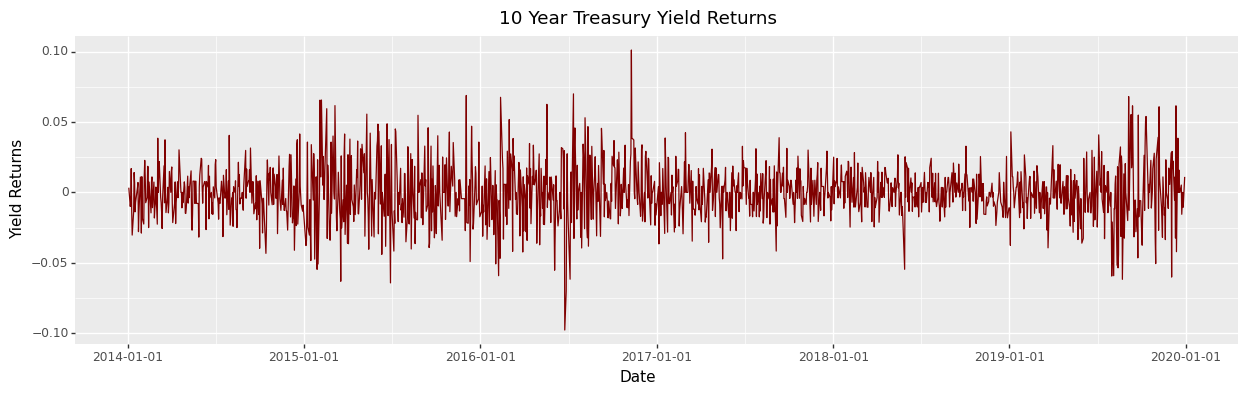

<ggplot: (8774688157540)>

In [47]:
bond_returns = (ggplot(bond_data[['Returns']], aes(x=bond_data.index, y='Returns'))
        + geom_line(color='maroon')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='Yield Returns', title='10 Year Treasury Yield Returns')
        )
bond_returns